Notebook to accompany article by Arseniev-Koehler and Foster, "Teaching an algorithm what it means to be fat: machine-learning as a model for cultural learning." All code last checked on Python 3 in Windows 6/24/2018. Please cite our paper or [GitHub repo](https://github.com/arsena-k/Word2Vec-bias-extraction) if reused. 

# More Manly or Womanly? Measure Biases in Word2Vec Models with the Larsen Method

This project explores how language in the news is loaded with meanings of gender, morality, healthiness, and socio-economic status (SES). For example, which words are more masculine or feminine? Are certain words loaded with meanings of immorality or morality? 

In this code, we develop and then train a model to classify words with respect to each of these four dimensions (gender, morality, healthiness, and SES) on a set of training words. Then, we test model performance on a fresh set of testing words. 

Finally, we look at how language about body weight, such as "obese" and "slender,"  to see how these words are connoted with gender, morality, health, and social class. 

This notebook, Part C of our project, uses methods inspired by [Larsen et. al. 2016](https://arxiv.org/abs/1512.09300?context=cs). For two alternate methods to check the robustness of your findings, look at code for [Part B and Part D](https://github.com/arsena-k/Word2Vec-bias-extraction). 

We start by loading up a trained Word2Vec model on news. We include two possible pre-trained models from our paper. See [Part A](https://github.com/arsena-k/Word2Vec-bias-extraction) of this project for a tutorial on training and understanding a Word2Vec model.  

**Table of Contents**

* Part 1: [Load up libraries and a Word2Vec Model](#LoadUp)
* Part 2: [Explanation of Classification Method](#Motivation)
* Part 3: [Functions to Extract a Dimension](#HelperFunctions)
* Part 4: [Robustness Checks](#Robustness)
* Part 5: [Visualize how this Dimension Classifies words according to Gender, Morality, Health, and SES](#Results)

*This is a long notebook. For an abbreviated adventure, just do Parts 1-2 to get the ideas and see simple examples in Python,. Or, to just get to visualizing the results, do Parts 2, 4, and 5.*

<a id='LoadUp'></a>
# Part 1. Load up libraries and a Word2Vec Model

In [33]:
#load up (and install if needed) libraries
import numpy as np
from csv import writer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from gensim.models import Word2Vec, KeyedVectors
#from sklearn import preprocessing
#from sklearn.decomposition import PCA 
from statistics import mode, mean, stdev
#from random import randint
#from collections import Counter
import matplotlib.pyplot as plt
from scipy import spatial
from seaborn import stripplot
from pylab import rcParams
from pylab import xlim
%matplotlib inline
#np.set_printoptions(threshold=np.inf) #do this if you want to print full output

**Load up a pretrained Word2Vec Model**

*Option 1:* Use the Word2Vec model that we used in our paper, and trained on obesity and health related New York Times articles. Please see our paper for training details. 
* Download our model, called 'modelA_ALLYEARS_500dim_10CW' from our [OSF](https://osf.io/jvarx/files/), and put it in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 

In [18]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   Example based on my set-up of folders:
currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

*Option 2:* Use a pretrained Word2Vec Model from Google, trained on Google News
* Download a pre-trained model on GoogleNews, find link to download on this [site](https://code.google.com/archive/p/word2vec/) or direct link to [download here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the files, and make sure you have the one called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. 

In [4]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

#   Example based on my set-up of folders:
currentmodel=  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


<a id='Motivation'></a> 
# Part 2. Explanation of Classification Method

"Dimension," "direction" and "subspace" are used in this notebook interchangeably to refer to a vector that captures a bipolar concept such as gender which is often portrayed as ranging continuosly from hypermasculine to hyperfeminine, or socioeconomic status (SES) which ranges from poor to rich. 

This notebook explores how a language model (Word2Vec) **learns words with respect to these dimensions.** Word2Vec models words as numeric vectors, for a review of Word2Vec check out this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). We classify a word-vector by first finding the dimension (like gender), and then projecting the word-vector onto the vector representing the dimension. We get a scalar that corresponds to how far the word-vector lies at one end of the diemsnion or anotehr (e.g., how masculine or feminine the word-vector is).
* To use gender as an example - a larger, positive projection of a word onto the gender dimension suggests this word is learned as highly feminine, while a larger, negative projection of a word onto the gender dimension suggests that this word is learned as highly masculine. A word with a projection near zero suggests that Word2Vec learned this word as gender-neutral. 
* Dimensions in this juypter notebook that are ready for extraction are **gender, morality, health,** and **ses**. Code is modifiable to extract other dimensions that may be interesting: you will need to adjust the training/testing words and corresponding labels. 
* This code is written for use with Word2Vec models, modifiable for other word-vector models as well. 

For a more detailed motivation, please see Part 1 of the Jupyter Notebook in this Repo titled "More Manly or Womanly? A Geometric Approach to Biases in Word2Vec Models." This notebook accomplishes the same things using a different method to extract a dimension. 


**Want MORE detail on how we can extract dimension (like gender)?**


Let's look at gender as an example. To extract a gender dimension, we want to find a direction (vector) that correspond to gender. We'll call this vector $\overrightarrow{g}$. This vector might be visualized as an axis ranging from negative (masculine) to positive (feminine) with gender-neutral at 0. We can find $\overrightarrow{g}$ by subtracting a direction representing femininity from a direction representing masculinity (such as $\overrightarrow{femininity}-\overrightarrow{masculinity}$). Specifically, if we assume that the meanings of masculinity and femininity are largely equivalent (both human, about adults, nouns, singular, etc.) except for their opposite gender components, then subtraction cancels out all but the gender differences across each component. This gender component is our gender direction ($\overrightarrow{g}$). 

This requires finding some direction for femininity and some direction for masculinity. We'll get to that next- for now, assume we have found these two directions.

Each vector (direction) in our model is made up of N components, where N is the dimensionality of the vector space. We can write each vector or word-vector in terms of these N components, below. For example, the first component is $\overrightarrow{X}$, the second component is $\overrightarrow{Y}$, and the Nth component is $\overrightarrow{N}$. For brevity, in the math below we refer to the direction for feminity as $\overrightarrow{f}$ and the direction for masculnity as $\overrightarrow{m}$.


$\overrightarrow{f} = f_{1}\overrightarrow{X} + f_{2}\overrightarrow{Y} + ... + f_{N}\overrightarrow{N}$
and 
$\overrightarrow{m} = m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N}$


We assume that $\overrightarrow{f} - \overrightarrow{m}$ = $\overrightarrow{g}$, where $\overrightarrow{g}$ is a gender difference vector as described above.


$\overrightarrow{f} - \overrightarrow{m}$= $(f_{1}\overrightarrow{X} + f_{2}\overrightarrow{Y} + ... + f_{N}\overrightarrow{N}) - ( m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N})$


These components may be rearranged:

$\overrightarrow{f} - \overrightarrow{m} = (f_{1}- m_{1})\overrightarrow{X} + (f_{2}- m_{2})\overrightarrow{Y} + ... + (f_{N} - m_{N})\overrightarrow{N}$

$\overrightarrow{f} - \overrightarrow{m} = g_{1}\overrightarrow{X} +  g_{2}\overrightarrow{Y} + ... + g_{N}\overrightarrow{N}$

This leaves us with a N-dimensional vector corresponding to the vector $\overrightarrow{g}$, corresponding to *differences* between $\overrightarrow{masculinity}$ and $\overrightarrow{femininity}$.

That's great but..how do we find the vectors for femininity and masculinity? Well, we COULD just use some proxies, like the word-vectors for "woman" and "man." 

In [7]:
gender_direction_trial= currentmodel['woman']-currentmodel['man'] #subtracting the word-vector for man from that for woman
#print(gender_direction_trial) #this "direction" representing gender is just an N-dimensional vector. Not so meaningful to a human!

**Now how do we use this gender direction to find how a word-vector is gendered?**
We [project](https://en.wikipedia.org/wiki/Vector_projection) the word-vector onto the gender direction! If you're not familiar with projections and want a visual explanation, please see Part 1 of the notebook in this repo titled "Geometrically_Extract_Dimensions_with_Word2Vec"

Let's try this. First, load up a few helper functions:

In [8]:
%run helpers_partC.py

Do projections for a few words:

In [9]:
scalarproject_fem_1 = project(currentmodel['queen'],normalizeME(gender_direction_trial)) 
scalarproject_fem_2 = project(currentmodel['womanly'],normalizeME(gender_direction_trial))
scalarproject_masc_1 = project(currentmodel['king'],normalizeME(gender_direction_trial))
scalarproject_masc_2 = project(currentmodel['manly'],normalizeME(gender_direction_trial))

In [10]:
print(scalarproject_fem_1, scalarproject_fem_2, scalarproject_masc_1, scalarproject_masc_2) #take a look at the projections

[ 0.05830791] [ 0.06917524] [-0.02321538] [-0.008906]


If this is working on your trained Word2Vec model, you should see that the feminine words lie on one side of the gender direction, and the masculine words on the other side of the gender direction. In my model, for example, all the feminine words have positive scalar projections and all the masculine words have negative scalar projections. 

To find dimensions for other concepts, we just use other training words, like healthy-ill to find a "health" direction. Try it out by modifying the code above! 

### More realistically...

...this method captures the true gender difference alongside other differences and error. These proxies of "wooman" and "man" might not be so great, and so this method captures the true gender difference alongside other differences and error. Instead, we can use a variety of words representing femininity, such as she, her, and woman, and then take the *average* of these vectors to get a better proxy for femininity. We can do the same for masculinity, and then subtract these two averages to get a better measure of our gender direction.

The remainder of this notebook does this, using a large set of training words. We look at three directions in this notebook: gender, morality, health, and SES. This notebook also includes steps to evaluate the robustness of the extracted direction on the training words, and on a new, unseen set of testing words. Finally, we project a new set of words (obesity keyword) onto the direction to see the meaning of obesity with respect to gender, morality, health, and SES.


### Now, let's extract a dimension more robustly

<a id='HelperFunctions'></a> 

# Part 3. Some Helper Functions to Extract a Dimension


In [5]:
%run helpers_partC.py #helpers_partC.py has a lot of longer functions that we'll use, in a separate file so that this notebook is more visually appealing
# %load helpers_partC.py #uncomment and run this to directly see ALL contents of helpers_partC.py that we'll use, but the most important ones are explained below

**select_training_set()** is a function to select correponding training words to represent the two ends of the dimension:

* Under the hood, this function includes sets of words that represent extremes of the dimension we want to capture. 
* To look at the final list of words, check out "pos_word_list" and "neg_word_list" or refer to the code in helpers_partC.py
* To keep track of the words, we refer to words at one end of any dimension as pos_words, and the other end as neg_words. 
* Our methods were developed using a Word2Vec model trained on the New York Times, so the vocabulary used in training and testing may not exactly match the vocabulary of your model. If a word is not in the vocabulary of your model, this function by default lets you know and then replaces the word with a generic word. For example, if "teenage_girl", or "twin_sister" is not in the vocabulary they will be replaced with the generic feminine word for the gender dimension, "woman." 

It is *fed*:
* the dimension we're interested in ('gender', 'moral', 'health', or 'ses')
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel.

It *returns*:
* pos_word_list= list of the words used for training the "positive" side of the dimension
* neg_word_list= list of the words used for training the "negative" side of the dimension
* pos_words= word-vectors corresponding to words used for training the "positive" side of the dimension
* neg_words= word-vectors corresponding to words used for training the "negative" side of the dimension
* train_classes_pos= expected classes of words used to train the "positive" side of the dimension
* train_classes_neg= expected classes of words used to train the "negative" side of the dimension

It also *prints* the number of positive and negative words used in training.

In [40]:
#example of how to use
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender', currentmodel)

Number of pos words: 85 Number of neg words: 85


**MEAN_get_directionVec_differences()** is a function to take the difference between the means of two set of word-vectors. 

It is *fed*:
* positive and negative training words we'll select with select_training_set()
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel
* optionally, indices to specify the set of training words from pos_words and neg_words we'll use, the default is None such that all training data is used.  

It *returns*:
* a direction corresponding to the training words it was fed, such as direction to represent gender, as described earlier. 
* for example, given the gender training word-vectors, it *returns* the difference between the mean of the feminine word-vecotrs and the mean of the masculine word-vectors.

In [41]:
#example of how to use
genderdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

<p> <span style="color:blue">**AT THIS POINT,** </span> you can continue to Part 4 to examine the robustness of these methods, or skip right to [Part 5](#Results) to just get to some results. <p>
 

<a id='Robustness'></a> 
# Part 4. Robustness Checks

**FIRST, Let's see how robust our methods are to the specific training words we use. We'll do cross validation on training words:**

Cross validation, with **do_kfold()** lets us see how well our dimension classifies our training words. More specifically, we use a subset of training words to extract the dimension and and look at how the dimension classifies 1) this subset of words and 2) the held-out words. We can do this for various subsets and look the range of accuracies. As coded, each training subset includes all but one training word ("leave one out" cross validation). This process tells us, for example, how robust our methods are to our word choices, and if there is any overfitting to the training words. 

This function is *fed* a dimenions ('gender', 'moral', 'health', or 'ses') and a trained Word2Vec model. It *returns* the average and standard deviation of accuracies across the multiple training subset and held-out subsets. 

In [11]:
do_kfold('gender' , currentmodel) #CHANGE here to select the dimension you are interested in. this is leave-one-out cross-validation

Number of pos words: 85 Number of neg words: 85
Mean Accuracy across Training Subsets:0.958753501401
Standard Deviation of Accuracy across Training Subsets:0.0017876584499109034
Mean Accuracy across Held-Out Subsets: 0.947058823529
Standard Deviation of Accuracy across Held-Out Subsets: 0.15475651789806066


In [12]:
do_kfold('moral' , currentmodel) #CHANGE here to select the dimension you are interested in. this is leave-one-out cross-validation

Number of pos words: 80 Number of neg words: 80
Mean Accuracy across Training Subsets:0.99375
Standard Deviation of Accuracy across Training Subsets:0.0007076164485758866
Mean Accuracy across Held-Out Subsets: 0.99375
Standard Deviation of Accuracy across Held-Out Subsets: 0.05590169943749474


In [ ]:
do_kfold('health' , currentmodel) #CHANGE here to select the dimension you are interested in. this is leave-one-out cross-validation

In [ ]:
do_kfold('ses' , currentmodel) #CHANGE here to select the dimension you are interested in. this is leave-one-out cross-validation

**SECOND, let's look to see if these directions are unique**

Our concern was that all these dimensions might just be capturing valence. 

In [56]:
#extract all four direction vectors:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender', currentmodel)
genderdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral', currentmodel)
moraldirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health', currentmodel)
healthdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses', currentmodel)
sesdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

#look at cosine simiarlity between each possible pair of direction vectors. Cosine similarity will tell us if these directions are capturing the exact same meaning, in which case the cosine similarity will be -1 or 1. 
print("Cosine Similarity between gender and morality is: " + str(1 - spatial.distance.cosine(genderdirectionVec, moraldirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and health is: " + str(1 - spatial.distance.cosine(genderdirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and ses is: " + str(1 - spatial.distance.cosine(genderdirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and health is: " + str(1 - spatial.distance.cosine(moraldirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and ses is: " + str(1 - spatial.distance.cosine(moraldirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between health and ses is: " + str(1 - spatial.distance.cosine(healthdirectionVec, sesdirectionVec))) #similarity is 1-distance

Number of pos words: 85 Number of neg words: 85
Number of pos words: 80 Number of neg words: 80
Number of pos words: 65 Number of neg words: 65
Number of pos words: 50 Number of neg words: 50
Cosine Similarity between gender and morality is: 0.087976276544
Cosine Similarity between gender and health is: 0.114006483185
Cosine Similarity between gender and ses is: -0.0545605384329
Cosine Similarity between morality and health is: 0.702924952102
Cosine Similarity between morality and ses is: 0.325370062874
Cosine Similarity between health and ses is: 0.262614712385


From Word2Vec models used to develop this code, morality and health are quite similar, though not exactly the same. Gender is not similar to any others, and health, morality, and SES have some similarity. We expect (and should see!) some similarity between morality, SES, and health given that they do include some amount of valence, and are tightly interwtined (e.g., health is moralized). 

Code below to save your extracted directions as a .CSV. 

In [11]:
np.savetxt("genderdirectionVec_altMEAN.csv", genderdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("moraldirectionVec_altMEAN.csv", moraldirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("healthdirectionVec_altMEAN.csv", healthdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("sesdirectionVec_altMEAN.csv", sesdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!

<a id='Results'></a> 
# Part 5: Let's extract a dimension (gender, morality, health, or socioeconomic status) and then see how words are classified according to that dimension

For each dimension, we'll look at how the dimension classifies the **training** words used to find the dimension and then a fresh set of **testing** words *not* used to find the dimension.

Finally, we'll look at how the dimension classifies a set of **words about obesity and body weight**. Is obesity connoted with feminininity or masculinity? Morality or immorality? Health or illness? Wealth or poverty?  Here you can stick in your own words too and see how they are classified. 

#### Select the subspace you want to examine below, with our trained model: 

In [26]:
class subspaceselector:
    def __init__(self):
        self.subspaceselection='gender' #CHANGE to: 'gender', 'moral' , 'health, or 'ses' 
    def printsubspace(self):
        return(str(self.subspaceselection))
    def pos_coded(self):
        return('Feminine') #CHANGE to: Feminine, Moral, Healthy, or High SES, this is just for prettier plotting, based on the dimension you selected in this code block. 
    def neg_coded(self):
        return('Masculine') #CHANGE to: Masculine, Immoral, Unhealthy, or Low SES, just is just for prettier plotting, based on the dimension you selected in this code block. 

subspace=subspaceselector()

**Run do_projections()** to lump together a lot of the functions we've used so far, to finally RUN our Larsen Method to classify words!

In brief, this function gives us predictions, words, and expected classes for our training and testing set. It will then print the training and testing accuracy for the subspace you selected in subspaceselector(), above. 

It is *fed*:
* the dimension we're interested in ('gender', 'moral', 'health', or 'ses'), which you specified abvoe with subspaceselector
* optionally, a set of words you want to classify (we'll look at obese lexicon later).
* our trained Word2Vec model we loaded earlier in this notebook, called currentmodel

It *returns*:
* train_word_list = set of training words
* predictions_train = predicted classes for the training words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_train = predictions (scalars) for the training words. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.
* train_classes = expected classes for the training set of words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* test_word_list = set of testing words. 
* predictions_test = predicted classes for the testing words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_test = predictions (scalars) for the testing words. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.
* test_classes = expected classes for the testing set of words. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* predictions_new_word_list = predicted classes for the new words of interest. 1 is feminine/moral/healthy/high SES. 0 is masculine/immoral/unhealthy/low SES.
* projections_new_word_list = predictions (scalars) for the new words of interest. Postive values are feminine/moral/healthy/high SES. Negative values are masculine/immoral/unhealthy/low SES.


In [27]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(subspace.printsubspace(), None, currentmodel)

Number of pos words: 85 Number of neg words: 85
Number of test words in model vocabulary, out of 60: 39
Percent- Training accuracy: 0.958823529412 Testing accuracy: 0.948717948718
Number- Training accuracy: 163 Testing accuracy: 37


####  Visualize Performance of Our Model on Test Words for the Dimension Selected Above (in subspaceselector):

Number of pos words: 85 Number of neg words: 85
Number of test words in model vocabulary, out of 60: 39
Percent- Training accuracy: 0.958823529412 Testing accuracy: 0.948717948718
Number- Training accuracy: 163 Testing accuracy: 37


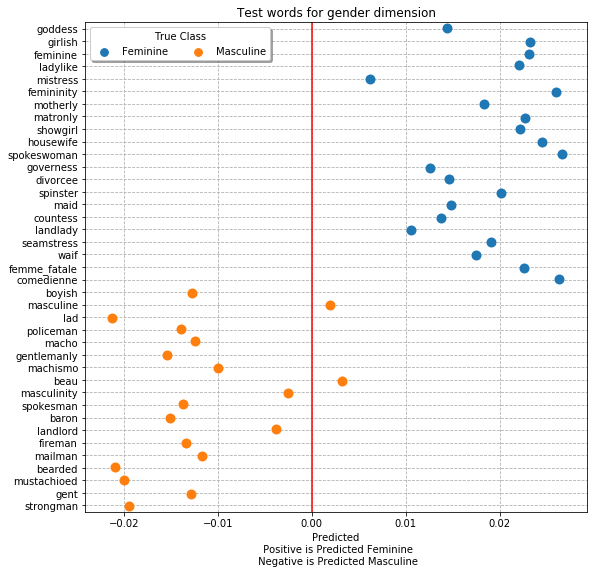

In [34]:
#get words, predictions, and classes for training and testing set
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(subspace.printsubspace(), None, currentmodel)
    
#visualization
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])

test_classes_relabeled=[] #quick hack to get legend to show Positive/Negative instead of 0/1
for i in test_classes:
    if i==1:
        test_classes_relabeled.append(subspace.pos_coded())
    else:
        test_classes_relabeled.append(subspace.neg_coded())

myplot= stripplot(projections_test, test_word_list, test_classes_relabeled, jitter=True, size=10)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title="True Class", fancybox=True)

plt.axvline(x=0, color='r', linestyle='-')
plt.title('Test words for '+ subspace.printsubspace() + ' dimension')
plt.xlabel('Predicted' + '\n Positive is Predicted ' + subspace.pos_coded() + '\n Negative is Predicted ' + subspace.neg_coded())
myplot.grid(b=True, linestyle='dashed')
plt.show()

#### Now lets try with obese words:

normal_weight was not in this model's vocabulary and has been removed
seriously_overweight was not in this model's vocabulary and has been removed
Number of pos words: 85 Number of neg words: 85
Number of test words in model vocabulary, out of 60: 39
Percent- Training accuracy: 0.958823529412 Testing accuracy: 0.948717948718
Number- Training accuracy: 163 Testing accuracy: 37


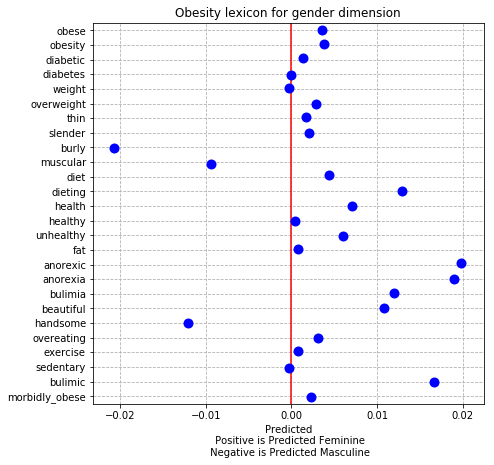

In [35]:
obese_words_seeifinmodel=['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                'seriously_overweight']
obese_words= []

#check if these words are in your model
for i in obese_words_seeifinmodel:
    try:
        currentmodel[i]
        obese_words.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue
    
#get words, predictions, and classes for training and obesity set
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test,\
    test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(subspace.printsubspace(), obese_words, currentmodel)
    
#visualization
rcParams['figure.figsize'] = 7, 7
#xlim([-.03, .03])
myplot= stripplot(projections_new_word_list, obese_words, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Obesity lexicon for '+ subspace.printsubspace() + ' dimension')
plt.xlabel('Predicted' + '\n Positive is Predicted ' + subspace.pos_coded() + '\n Negative is Predicted ' + subspace.neg_coded())
myplot.grid(b=True, linestyle='dashed')
plt.show()

#### Write projection for training/testing/obese keywords results to a CSV

In [142]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, \
    projections_test, test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections(subspace.printsubspace(), obese_words, currentmodel)

with open(r'Results.csv', 'a') as f:
    writer0 = writer(f)
    writer0.writerow([subspace.printsubspace() + '_Train']*len(train_word_list))  #change the headings as needed for Gender,Moral, Health, SES
    writer0.writerow(train_word_list)
    writer0.writerow(train_classes)
    writer0.writerow(predictions_train)
    writer0.writerow(projections_train)

    writer0.writerow([subspace.printsubspace() + '_Test']*len(test_word_list)) #change the headings as needed for Gender, Moral, Health, SES
    writer0.writerow(test_word_list)
    writer0.writerow(test_classes)
    writer0.writerow(predictions_test)
    writer0.writerow(projections_test)
    
    writer0.writerow([subspace.printsubspace() + '_Obesity']*len(obese_words)) #change the headings as needed for Gender, Moral, Health, SES, and if another set of words other than the obese_words are used here
    writer0.writerow(obese_words)
    writer0.writerow(predictions_new_word_list)
    writer0.writerow(projections_new_word_list)

Number of pos words: 50 Number of neg words: 50
Number of test words: 60
Percent- Training accuracy: 0.94 Testing accuracy: 0.966666666667
Number- Training accuracy: 94 Testing accuracy: 58


#### Extra - For gender, examine how a few stereotypically gendered words are classified with this method

Number of pos words: 85 Number of neg words: 85
Number of test words in model vocabulary, out of 60: 39
Percent- Training accuracy: 0.958823529412 Testing accuracy: 0.948717948718
Number- Training accuracy: 163 Testing accuracy: 37


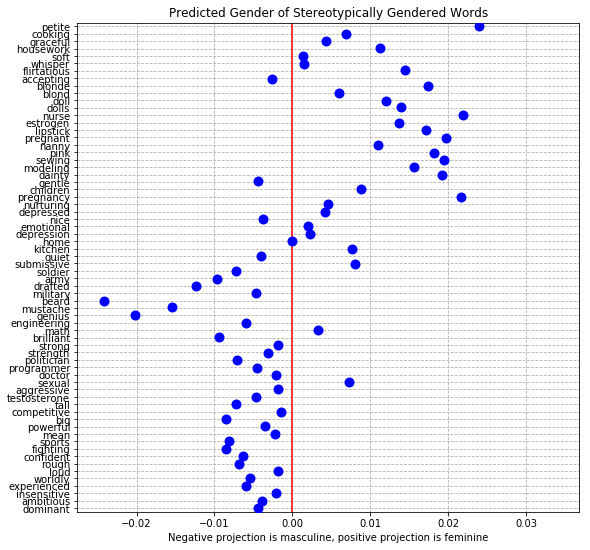

In [36]:
gender_stereotypes_seeifinmodel=['petite', 'cooking', 'graceful','housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
gender_stereotypes= []

#check if these words are in your model
for i in gender_stereotypes_seeifinmodel:
    try:
        currentmodel[i]
        gender_stereotypes.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue
        
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, \
    projections_test, test_classes, predictions_new_word_list, projections_new_word_list  \
    = do_projections('gender', gender_stereotypes, currentmodel)
    
#Visualization
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])
myplot= stripplot(projections_new_word_list, gender_stereotypes, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Predicted Gender of Stereotypically Gendered Words')
plt.xlabel('Negative projection is masculine, positive projection is feminine')
myplot.grid(b=True, linestyle='dashed')
plt.show()